# Bayesian Breast Cancer classifier using MCDropout Bayesian approximation

The input consists of gene expression levels of a patient (vector of numbers), the label consists of the patient breast cancer subtype: LUMINAL A or LUMINAL B.
Implement a simple MLP classifier with MCDropout approximation to get for each test patient the class label and the class probability.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
import numpy as np
import keras

dataset = pd.read_csv('dataset_LUMINAL_A_B.csv')

X, y = dataset.values[:, 1:], dataset['l']

pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
X = pipeline.fit_transform(X)

encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [2]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input

In [3]:
class MCDropout(Dropout):
    def call(self,inputs,training=False):
        return super().call(inputs, training=True)

model = Sequential([
    Input(shape=(X_train.shape[1])),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model.fit(X_train, y_train,epochs=100, verbose=0)

2023-11-17 23:25:16.847777: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


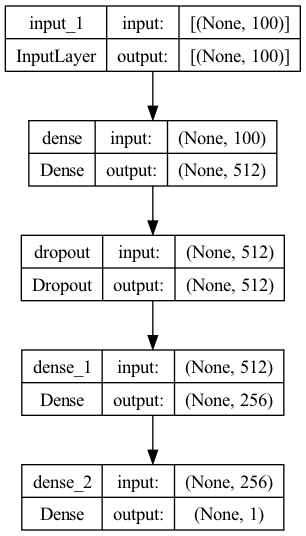

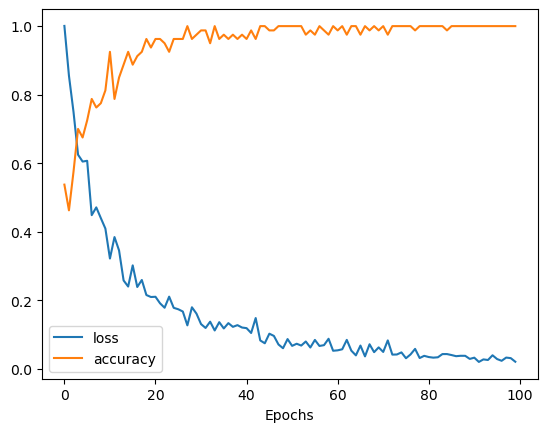

In [4]:

pd.DataFrame(history.history).plot(
    xlabel="Epochs",
)

from IPython.display import Image 
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [5]:
from sklearn.metrics import accuracy_score

MC_ITERATIONS = 100
acc = []
mc_predictions = np.zeros((MC_ITERATIONS, X_test.shape[0]))
for i in range(MC_ITERATIONS):
    y_pred = model(X_test, training=True)
    mc_predictions[i] = y_pred[:, 0]
    y_pred_t = np.array(y_pred[:, 0]>0.5, dtype=int)
    acc.append(accuracy_score(y_test, y_pred_t))

In [6]:
mc_predictions.shape

(100, 20)

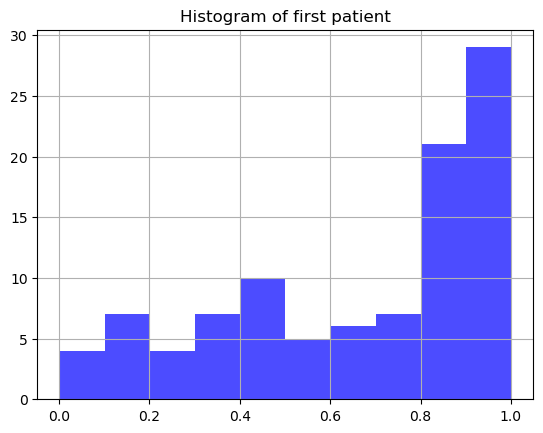

In [30]:
from matplotlib import pyplot  as plt

PATIENT=0
patient_mc_predictions = mc_predictions[:,PATIENT]



plt.hist(patient_mc_predictions, orientation='vertical', color='blue', alpha=0.7)
plt.title('Histogram of first patient')
plt.grid(True)
plt.show()



In [47]:
from scipy import stats

PATIENT=0
patient_mc_predictions = mc_predictions[:,PATIENT]
patient_hist, patient_bin_edges = np.histogram(patient_mc_predictions)

label = np.argmax(patient_hist)
pdf = stats.norm.pdf(patient_bin_edges[label], loc=np.mean(patient_mc_predictions), scale=np.std(patient_mc_predictions))

print(f'probability: {pdf:.2}')

probability: 0.99
